### Run biasnet in Jupyter notebook

In [1]:
import joblib, glob, os, sys,json
from pprint import pprint
import numpy as np, pandas as pd
from hypopt import GridSearch
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import pylab

In [2]:
def get_results(y_test, y_pre, y_pro):
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pre).ravel()
    SP = float(tn)/(tn+fp)

    results = {}
    results['roc_auc'] = metrics.roc_auc_score(y_test, y_pro)
    results['accuracy'] = metrics.accuracy_score(y_test, y_pre)
    results['f1_score'] = metrics.f1_score(y_test, y_pre)# average='binary' by default
    results['Recall'] = metrics.recall_score(y_test, y_pre)
    results['Precision'] = metrics. precision_score(y_test, y_pre)
    results['SP'] = SP
    results['cohen_kappa'] = metrics.cohen_kappa_score(y_test, y_pre)
    results['mcc'] = metrics.matthews_corrcoef(y_test, y_pre)
    
    return results

def run_biasnet(features, models):
    models = glob.glob(models+'/*')
    avalon = np.load(features+'/'+'b_g_labels_clean_test_avalon_fp.npy')
    lecfp4 = np.load(features+'/'+'b_g_labels_clean_test_lecfp4_fp.npy')
    
    final_results = dict()
    
    avalon_x_test = avalon[:,:-1]
    avalon_y_test = avalon[:,-1]
    lecfp4_x_test = lecfp4[:,:-1]
    lecfp4_y_test = lecfp4[:,-1]
    
    for m in models:
        if m.endswith('rf'):
            model = joblib.load(m)
            y_pre = model.predict(avalon_x_test)
            y_pro = model.predict_proba(avalon_x_test)[:, 1]
            results = get_results(avalon_y_test, y_pre, y_pro)
            final_results['RF'] = results
        elif m.endswith('xgb'):
            model = joblib.load(m)
            y_pre = model.predict(avalon_x_test)
            y_pro = model.predict_proba(avalon_x_test)[:, 1]
            results = get_results(avalon_y_test, y_pre, y_pro)
            final_results['XGB'] = results
        else:
            model = joblib.load(m)
            y_pre = model.predict(lecfp4_x_test)
            y_pro = model.predict_proba(lecfp4_x_test)[:, 1]
            results = get_results(lecfp4_y_test, y_pre, y_pro)
            final_results['MLP'] = results
        
    return final_results
    

In [3]:
final_results = run_biasnet('../../numpyFiles', '../../models')
pprint(final_results, indent=4)

{   'MLP': {   'Precision': 0.7407407407407407,
               'Recall': 0.8,
               'SP': 0.8627450980392157,
               'accuracy': 0.8421052631578947,
               'cohen_kappa': 0.649500384319754,
               'f1_score': 0.7692307692307692,
               'mcc': 0.6506114385895281,
               'roc_auc': 0.8407843137254901},
    'RF': {   'Precision': 0.782608695652174,
              'Recall': 0.72,
              'SP': 0.9019607843137255,
              'accuracy': 0.8421052631578947,
              'cohen_kappa': 0.6349079263410728,
              'f1_score': 0.7499999999999999,
              'mcc': 0.636086593313052,
              'roc_auc': 0.8188235294117647},
    'XGB': {   'Precision': 0.782608695652174,
               'Recall': 0.72,
               'SP': 0.9019607843137255,
               'accuracy': 0.8421052631578947,
               'cohen_kappa': 0.6349079263410728,
               'f1_score': 0.7499999999999999,
               'mcc': 0.636086593313052,
  

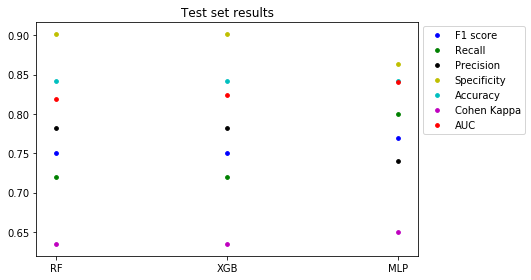

In [4]:
model_names = list(final_results.keys())
precision, recall, sp, acc, kappa, f1, roc = [], [], [], [], [], [], []

for i in model_names:
    precision.append(final_results[i]['Precision'])
    recall.append(final_results[i]['Recall'])
    sp.append(final_results[i]['SP'])
    f1.append(final_results[i]['f1_score'])
    acc.append(final_results[i]['accuracy'])
    kappa.append(final_results[i]['cohen_kappa'])
    roc.append(final_results[i]['roc_auc'])

plt.rc('xtick',labelsize=10)
plt.scatter(model_names, f1, c='b',s=14, label='F1 score')
plt.scatter(model_names, recall, c='g',s=14, label='Recall')
plt.scatter(model_names, precision, c='k',s=14, label='Precision')
plt.scatter(model_names, sp, c='y',s=14, label='Specificity')
plt.scatter(model_names, acc, c='c',s=14, label='Accuracy')
plt.scatter(model_names, kappa, c='m',s=14, label='Cohen Kappa')
plt.scatter(model_names, roc, c='r',s=14, label='AUC')
plt.title("Test set results")
plt.tight_layout()
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()